# Agrupación de tarjetas de crédito

### Daniel Marín López
---

### Importamos librerías

In [ ]:
!pip install kneed

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from kneed import KneeLocator

### Variables Globales y Funciones

In [ ]:
Kmax = 11 # Número máximo de clusters
SEED = 42

In [ ]:
def BIC(K, grupos, X):
  """
  K: Número de grupos (clusters)
  grupos: Vector que contiene los grupos de los datos
  X: Matriz de datos
  """
  N = X.shape[0] # Número de datos
  P = X.shape[1] # Número de variables
  xi = np.zeros((1,K)) # Vector xi

  # Calculamos el sumario de xi en la fórmula
  for k in range(0, K):
    suma = 0
    for j in range(0, P):
      sigma = np.square(np.std(X[:, j]))
      sigma_j = np.square(np.std(X[grupos==k, j]))
      suma += 0.5*np.log(sigma + sigma_j)

    n_k = sum(grupos==k) # Número de elementos en el grupo k
    xi[0, k] = -n_k*suma

  bic = -2*np.sum(xi) + 2*K*P*np.log(N)
  return bic

In [ ]:
def Elbow_BIC_iter(Kmax=10, X=None, method='elbow'):
  """
  Kmax: Número máximo de clusters
  X: Matriz de datos
  method: Método de cálculo de BIC o Elbow
  """
  results = []
  K_range = range(1, Kmax)

  for k in K_range:
      kmeans = KMeans(n_clusters=k, random_state=SEED, n_init=10)
      if method == 'elbow':
        kmeans.fit(X)
        results.append(kmeans.inertia_)
      elif method == 'bic':
        grupos = kmeans.fit_predict(X)
        results.append(BIC(k, grupos, X))
      else:
        raise ValueError("El método debe ser 'elbow' o 'bic'")

  if method == 'bic':
    bic_k = np.argmin(results) + 1
    return K_range, results, bic_k
  else:
    kl = KneeLocator(K_range, results, curve="convex", direction="decreasing")
    elbow_k = kl.elbow
    return K_range, results, elbow_k

---
### Ejercicio

La agrupación de tarjetas de crédito significa agrupar a los titulares de tarjetas de crédito en función de sus hábitos de compra, límites de crédito y muchos más factores financieros. También se conoce como segmentación de tarjetas de crédito. Dicho análisis de agrupamiento ayuda a las empresas a encontrar a sus clientes potenciales y muchas más estrategias de marketing.

Para la tarea de agrupación de tarjetas de crédito con Machine Learning, necesitamos tener un conjunto de datos basado en el historial de compras de los titulares de tarjetas de crédito.

---

### 1. Carga de los datos
---

Cargamos los datos.

In [ ]:
data = pd.read_csv('CC GENERAL.csv')
data.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


Y una cosa que podemos notar es que el dataset contiene muchas características las cuales no sabemos cuáles son las adecuadas para visualizar nuestros resultados.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

### 2. Valores faltantes y escalado
---

El dataset muestra un total de 17 características, de las cuales el ID no nos interesa ya que son valores únicos. Tratamos los valores faltantes con la media y escalamos los datos.

In [ ]:
X = data.drop(['CUST_ID'], axis=1)

X = X.fillna(X.mean())

std_scaler = StandardScaler()
X_std = std_scaler.fit_transform(X)

### 3. Visualización
---

Una vez nuestros datos están escalados, toca la visualización. Como tenemos 16 características es difícil hacer una visualización si no tenemos claro que características son buenas para la agrupación, es por ello que usaremos el PCA para esta tarea ya que esto nos devolverá tantas componentes como deseemos. En mi caso usaré 2 componentes.

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)
print(f"Varianza explicada por cada componente: {pca.explained_variance_ratio_}")

pd.DataFrame(np.matrix.transpose(pca.components_), columns=['PC-1', 'PC-2'], index=X.columns)

Varianza explicada por cada componente: [0.27290037 0.20301991]


,PC-1,PC-2
BALANCE,0.101077,0.403957
BALANCE_FREQUENCY,0.120043,0.130537
PURCHASES,0.411642,0.041038
ONEOFF_PURCHASES,0.346407,0.062872
INSTALLMENTS_PURCHASES,0.336814,-0.018533
CASH_ADVANCE,-0.023343,0.439242
PURCHASES_FREQUENCY,0.321493,-0.190780
ONEOFF_PURCHASES_FREQUENCY,0.294633,-0.017924
PURCHASES_INSTALLMENTS_FREQUENCY,0.274710,-0.178601
CASH_ADVANCE_FREQUENCY,-0.089139,0.434082


Vemos que la varianza explicada de cada componente se encuentra en torno a un 20%, si las sumamos esto da un 40% del total. Lo que indica que no refleja mucho la información de nuestro conjunto de datos.

### ¿Se puede tener en cuenta la PCA?

Como el resultado es bastante bajo, la PCA en este caso solo se usará para la visualización de los datos ya que la cantidad de características es muy grande en este problema. Es normal que se pierda información en el proceso, pero como solo queremos esto para visualizar nuestros datos no se tendrá en cuenta para el resto de fases hasta la visualización de los resultados.

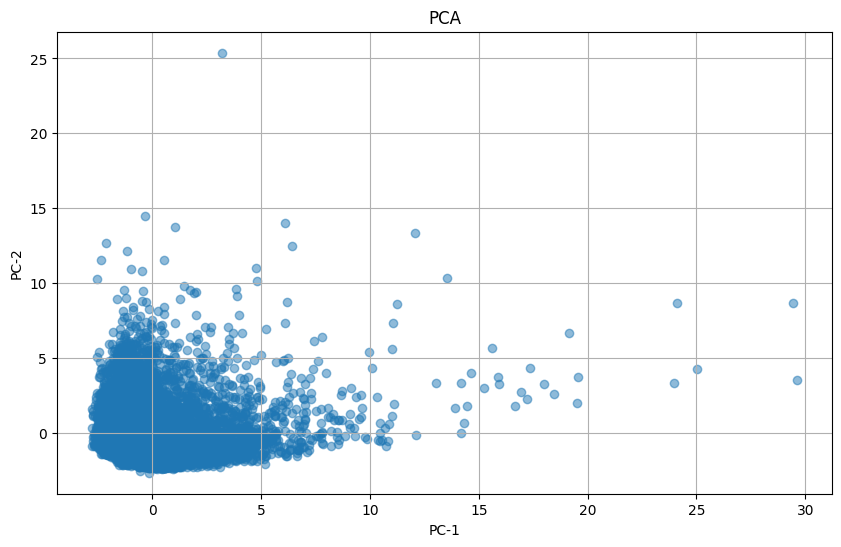

In [ ]:
plt.figure(figsize=(10, 6))

plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.xlabel('PC-1')
plt.ylabel('PC-2')
plt.title('PCA')
plt.grid(True)
plt.show()

Observamos que los datos se juntan mucho en la parte inferior izquierda de la gráfica.

### 4. Buscar el K más óptimo
---

De nuevo usamos K-means y sacamos el K tando de la función BIC como de la suma de las distancias al cuadrado.

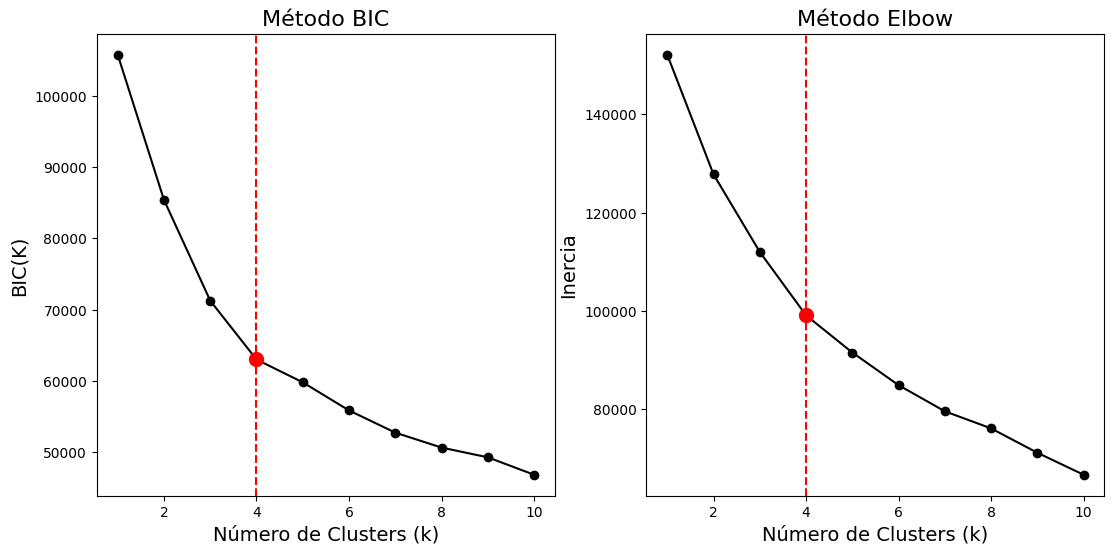

In [ ]:
K_range, results, elbow_k = Elbow_BIC_iter(Kmax=Kmax, X=X_std, method='elbow')
_, results_bic, bic_k = Elbow_BIC_iter(Kmax=Kmax, X=X_std, method='bic')

plt.figure(figsize=(13, 6))

plt.subplot(1, 2, 1)
plt.plot(K_range, results_bic, "ko-")
plt.title("Método BIC", fontsize=16)
plt.xlabel("Número de Clusters (k)", fontsize=14)
plt.ylabel("BIC(K)", fontsize=14)
plt.axvline(x=bic_k, linestyle="--", color="red", label=f'Codo en k={bic_k}')
plt.scatter(bic_k, results_bic[bic_k - 1], color='red', s=100, zorder=3)

plt.subplot(1, 2, 2)
plt.plot(K_range, results, "ko-")
plt.title("Método Elbow", fontsize=16)
plt.xlabel("Número de Clusters (k)", fontsize=14)
plt.ylabel("Inercia", fontsize=14)
plt.axvline(x=elbow_k, linestyle="--", color="red", label=f'Codo en k={elbow_k}')
plt.scatter(elbow_k, results[elbow_k - 1], color='red', s=100, zorder=3)

plt.show()

Vemos que ambos llegan al mismo K, siendo un total de 4 grupos.

### 5. Creación del modelo
---

Creamos y entrenamos nuestro modelo K-means.

In [ ]:
kmeans_model = KMeans(n_clusters=elbow_k, random_state=SEED, n_init=10)
kmeans_model.fit(X_std)

KMeans(n_clusters=np.int64(4), n_init=10, random_state=42)

Y sacamos los grupos y los centroides, también imprimimos cual es su BIC e inercia.

In [ ]:
groups = kmeans_model.predict(X_std)
centroides = kmeans_model.cluster_centers_

print(f"BIC: {BIC(elbow_k, groups, X_std)}")
print(f"Inercia: {kmeans_model.inertia_}")

BIC: 62989.02857205319
Inercia: 99073.93826774786


### 6. Visualización de resultados
---

Por último, visualizamos los resultados. De nuevo, usamos la PCA para visualizar los grupos.

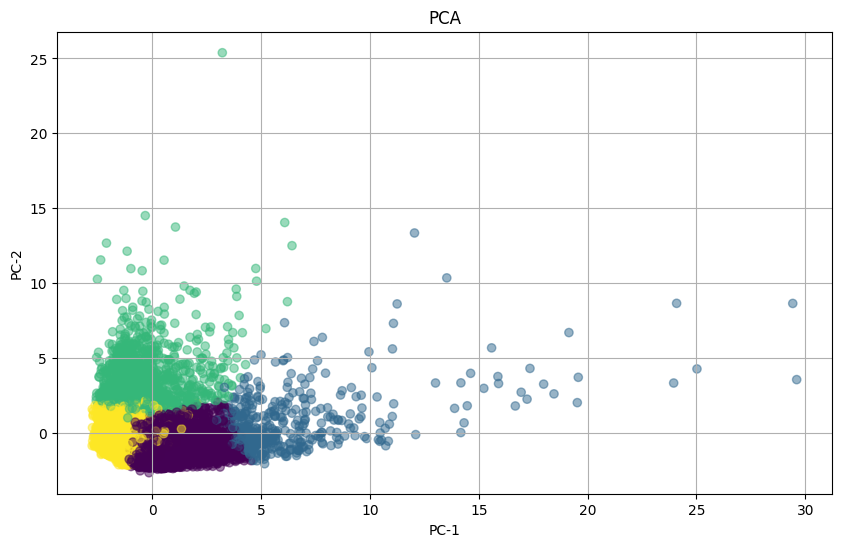

In [ ]:
plt.figure(figsize=(10, 6))

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=groups, alpha=0.5)
plt.xlabel('PC-1')
plt.ylabel('PC-2')
plt.title('PCA')
plt.grid(True)
plt.show()

Podemos ver que los grupos de abajo se mezclan un poco mientras hay uno que está encima de los demás.